In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import librosa
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import language_tool_python
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
from IPython.display import display, Markdown


C:\Users\mdriz\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:


# Copy the entire AudioGrammarScoringModel class here
class AudioGrammarScoringModel:
    def __init__(self, base_path='./'):
        """
        Initialize the model with paths to the competition data
        
        Args:
            base_path: Base path containing the data folders
        """
        self.base_path = base_path
        self.audio_path = os.path.join(base_path, 'audios/train/')
        self.test_audio_path = os.path.join(base_path, 'audios/test/')
        self.train_data = None
        self.test_data = None
        self.features_df = None
        self.model = None
        
        # Initialize ASR model (using Whisper for good accuracy)
        print("Initializing ASR model...")
        self.asr = pipeline("automatic-speech-recognition", model="openai/whisper-base")
        
        # Initialize grammar checker
        print("Initializing grammar checker...")
        self.grammar_tool = language_tool_python.LanguageTool('en-US')
        
        # Initialize pre-trained model for linguistic quality assessment
        print("Initializing linguistic quality model...")
        model_name = "textattack/roberta-base-CoLA"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.quality_model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        print("Initialization complete!")
        
    def load_data(self, train_file='train.csv', test_file='test.csv'):
        """Load training and test data"""
        train_path = os.path.join(self.base_path, train_file)
        test_path = os.path.join(self.base_path, test_file)
        
        # Load training data
        if os.path.exists(train_path):
            self.train_data = pd.read_csv(train_path, na_values=[''], keep_default_na=True)
            # Fill any missing values with 0
            self.train_data = self.train_data.fillna(0)
            # Ensure column names are standardized
            if 'filename' in self.train_data.columns and 'label' in self.train_data.columns:
                self.train_data = self.train_data.rename(columns={
                    'filename': 'audio_file',
                    'label': 'grammar_score'
                })
            print(f"Loaded {len(self.train_data)} training samples")
        else:
            print(f"Warning: Training file {train_path} not found.")
            
        # Load test data
        if os.path.exists(test_path):
            self.test_data = pd.read_csv(test_path, na_values=[''], keep_default_na=True)
            # Fill any missing values with 0
            self.test_data = self.test_data.fillna(0)
            # Ensure column names are standardized
            if 'filename' in self.test_data.columns:
                self.test_data = self.test_data.rename(columns={
                    'filename': 'audio_file'
                })
            print(f"Loaded {len(self.test_data)} test samples")
        else:
            print(f"Warning: Test file {test_path} not found.")
            
        # Display the first few rows to understand the data structure
        if self.train_data is not None:
            display(Markdown("### Training data sample:"))
            display(self.train_data.head())
            
            # Analyze the distribution of grammar scores
            display(Markdown("### Grammar score distribution:"))
            display(self.train_data['grammar_score'].describe())
            
            # Create a histogram of grammar scores
            plt.figure(figsize=(10, 6))
            sns.histplot(self.train_data['grammar_score'], bins=10, kde=True)
            plt.title('Distribution of Grammar Scores')
            plt.xlabel('Grammar Score')
            plt.ylabel('Count')
            plt.show()
        
    def extract_features(self, data_type='train', subset=None, force_recompute=False, save_features=True):
        """
        Extract features from audio files

        Args:
            data_type: 'train' or 'test' to specify which dataset to process
            subset: Number of samples to process (for testing), None for all
            force_recompute: If True, recompute features even if saved features exist
            save_features: If True, save features to disk after computation
        """
        # Check if features already exist
        features_path = os.path.join(self.base_path, f'{data_type}_features.pkl')

        if os.path.exists(features_path) and not force_recompute:
            print(f"Loading pre-computed features from {features_path}")
            with open(features_path, 'rb') as f:
                features_df = pickle.load(f)

            if subset is not None:
                features_df = features_df.head(subset)

            if data_type == 'train':
                self.features_df = features_df

            return features_df

        # Select the appropriate dataset and audio path
        if data_type == 'train':
            if self.train_data is None:
                raise ValueError("Training data not loaded. Call load_data() first.")
            data = self.train_data
            audio_path = self.train_audio_path  # Use train audio path
        elif data_type == 'test':
            if self.test_data is None:
                raise ValueError("Test data not loaded. Call load_data() first.")
            data = self.test_data
            audio_path = self.test_audio_path  # Use test audio path
        else:
            raise ValueError(f"Invalid data_type: {data_type}. Must be 'train' or 'test'.")

        # Create a subset for testing if specified
        if subset is not None:
            data = data[:subset].copy()
        else:
            data = data.copy()

        features = []

        print(f"Extracting features from {data_type} audio files...")
        for idx, row in tqdm(data.iterrows(), total=len(data)):
            audio_file = row['audio_file']
            file_audio_path = os.path.join(audio_path, audio_file)  # Use the appropriate audio path

            # Skip if file doesn't exist
            if not os.path.exists(file_audio_path):
                print(f"Warning: {file_audio_path} not found. Skipping.")
                continue

            # Process audio file
            feature_dict = self._process_audio_file(file_audio_path)

            # Add file information
            feature_dict['audio_file'] = audio_file

            # Add the ground truth score if available
            if 'grammar_score' in row:
                feature_dict['grammar_score'] = row['grammar_score']

            features.append(feature_dict)
    
    # Rest of the method remains the same
    # ...
        
        # Convert to DataFrame
        features_df = pd.DataFrame(features)
        
        # Store the features
        if data_type == 'train':
            self.features_df = features_df
        
        # Save features to disk if requested
        if save_features:
            with open(features_path, 'wb') as f:
                pickle.dump(features_df, f)
            print(f"Saved features to {features_path}")
        
        print(f"Extracted features for {len(features_df)} audio files")
        
        # Display feature correlation with grammar score if available
        if 'grammar_score' in features_df.columns and len(features_df) > 0:
            display(Markdown("### Feature correlation with grammar score:"))
            # Convert string columns to numeric, dropping non-numeric columns
            numeric_df = features_df.select_dtypes(include=[np.number])
            if 'grammar_score' in numeric_df.columns:
                correlations = numeric_df.corr()['grammar_score'].sort_values(ascending=False)
                display(correlations)
                
                # Create correlation heatmap
                plt.figure(figsize=(12, 10))
                correlation_matrix = numeric_df.corr()
                mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
                sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
                          fmt='.2f', square=True, linewidths=.5)
                plt.title('Feature Correlation Matrix')
                plt.tight_layout()
                plt.show()
        
        return features_df
    
    # Include all other methods from the original class here
    def _process_audio_file(self, audio_path):
        """Process a single audio file to extract features"""
        feature_dict = {}
        
        try:
            # Load audio
            audio, sr = librosa.load(audio_path, sr=16000)
            
            # Extract audio features
            feature_dict.update(self._extract_audio_features(audio, sr))
            
            # Transcribe audio with timestamp handling for long files
            try:
                transcription = self.asr(
                    {"array": audio, "sampling_rate": sr},
                    return_timestamps=True,  # Enable timestamp handling for long files
                    chunk_length_s=30  # Process in 30-second chunks
                )
                
                # Extract text from the transcription
                if isinstance(transcription, dict):
                    if "text" in transcription:
                        text = transcription["text"]
                    elif "chunks" in transcription:
                        # Combine text from chunks for long audio files
                        text = " ".join([chunk["text"] for chunk in transcription["chunks"]])
                    else:
                        text = ""
                else:
                    text = str(transcription)
                    
            except Exception as e:
                print(f"ASR Error for {audio_path}: {str(e)}")
                text = ""
            
            feature_dict['transcription'] = text.strip()
            
            # Extract text features only if we have transcription
            if text:
                feature_dict.update(self._extract_text_features(text))
            else:
                # Add default text feature values
                feature_dict.update({
                    'word_count': 0,
                    'error_count': 0,
                    'error_density': 0,
                    'sentence_count': 0,
                    'avg_sentence_length': 0,
                    'linguistic_quality': 0
                })
            
            # Calculate speech rate now that we have both duration and word count
            if feature_dict['duration'] > 0:
                feature_dict['speech_rate'] = feature_dict['word_count'] / (feature_dict['duration'] / 60.0)  # words per minute
            else:
                feature_dict['speech_rate'] = 0
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            # Set default values if processing fails
            feature_dict = {
                'duration': 0,
                'mean_energy': 0,
                'tempo': 0,
                'zero_crossing_rate': 0,
                'speech_rate': 0,
                'word_count': 0,
                'error_count': 0,
                'error_density': 0,
                'sentence_count': 0,
                'avg_sentence_length': 0,
                'linguistic_quality': 0,
                'transcription': ''
            }
            
        return feature_dict
    
    def _extract_audio_features(self, audio, sr):
        """Extract features from audio signal"""
        features = {}
        
        # Duration
        features['duration'] = librosa.get_duration(y=audio, sr=sr)
        
        # Energy features
        features['mean_energy'] = np.mean(np.abs(audio))
        
        # Tempo estimation
        onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        features['tempo'] = tempo
        
        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        features['zero_crossing_rate'] = np.mean(zcr)
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        
        # RMS energy
        rms = librosa.feature.rms(y=audio)
        features['rms_mean'] = np.mean(rms)
        
        # MFCC features (aggregate statistics)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc{i+1}_std'] = np.std(mfccs[i])
        
        return features
    
    def _extract_text_features(self, text):
        """Extract features from transcribed text"""
        features = {}
        
        # Basic text stats
        words = text.split()
        features['word_count'] = len(words)
        
        # Grammar errors
        grammar_errors = self.grammar_tool.check(text)
        features['error_count'] = len(grammar_errors)
        features['error_density'] = features['error_count'] / max(1, features['word_count'])
        
        # Sentence features
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        features['sentence_count'] = len(sentences)
        features['avg_sentence_length'] = features['word_count'] / max(1, features['sentence_count'])
        
        # Word length statistics
        if words:
            word_lengths = [len(word) for word in words]
            features['avg_word_length'] = sum(word_lengths) / len(words)
            features['max_word_length'] = max(word_lengths) if word_lengths else 0
        else:
            features['avg_word_length'] = 0
            features['max_word_length'] = 0
        
        # Linguistic quality assessment
        features['linguistic_quality'] = self._assess_linguistic_quality(text)
        
        # Extract specific grammar error types
        error_categories = {}
        for error in grammar_errors:
            category = error.ruleIssueType if hasattr(error, 'ruleIssueType') else 'other'
            error_categories[category] = error_categories.get(category, 0) + 1
            
        # Add top error categories as features
        for category, count in error_categories.items():
            safe_category = ''.join(c if c.isalnum() else '_' for c in category)
            features[f'error_{safe_category}'] = count
            
        # Additional linguistic features
        if text:
            features['unique_words_ratio'] = len(set(words)) / max(1, len(words))
            
            # Count punctuation marks
            features['comma_count'] = text.count(',')
            features['question_mark_count'] = text.count('?')
            features['exclamation_count'] = text.count('!')
            
            # Count specific parts of speech (simplified)
            features['pronoun_count'] = sum(1 for word in words if word.lower() in ['i', 'me', 'my', 'mine', 'you', 'your', 'yours', 'he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'we', 'us', 'our', 'ours', 'they', 'them', 'their', 'theirs'])
            features['article_count'] = sum(1 for word in words if word.lower() in ['a', 'an', 'the'])
            features['conjunction_count'] = sum(1 for word in words if word.lower() in ['and', 'but', 'or', 'nor', 'for', 'yet', 'so', 'although', 'because', 'since', 'unless'])
        else:
            features['unique_words_ratio'] = 0
            features['comma_count'] = 0
            features['question_mark_count'] = 0
            features['exclamation_count'] = 0
            features['pronoun_count'] = 0
            features['article_count'] = 0
            features['conjunction_count'] = 0
            
        return features
    
    def _assess_linguistic_quality(self, text):
        """Use a pre-trained model to assess linguistic acceptability"""
        if not text.strip():
            return 0
            
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.quality_model(**inputs)
        
        # Get the predicted score (higher means more grammatically acceptable)
        acceptability_score = torch.softmax(outputs.logits, dim=1)[0][1].item()
        return acceptability_score
    
    def prepare_model_data(self, features_df=None, is_test=False):
        """Prepare data for model training"""
        if features_df is None:
            features_df = self.features_df
        
        if features_df is None or len(features_df) == 0:
            raise ValueError("No features available. Run extract_features() first.")
        
        # Drop rows with missing values
        if not is_test:
            features_df = features_df.dropna(subset=['grammar_score'])
        
        # Select numeric columns only, excluding 'grammar_score' and non-feature columns
        exclude_cols = ['audio_file', 'grammar_score', 'transcription']
        feature_cols = [col for col in features_df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        # Prepare X (features) and y (target)
        X = features_df[feature_cols]
        y = features_df['grammar_score']
        
        # Fill any remaining NaN values with 0
        X = X.fillna(0)
        
        print(f"Prepared {len(X)} samples with {len(feature_cols)} features")
        return X, y
    
    def train_with_cross_validation(self, cv=5, model_type='xgboost'):
        """Train and evaluate model with cross-validation"""
        print("Training with {}-fold cross-validation...".format(cv))
        
        # Prepare data
        try:
            X, y = self.prepare_model_data()
        except ValueError as e:
            print(f"Error preparing data: {e}")
            return
        
        if len(X) < cv:
            print(f"Error: Not enough samples ({len(X)}) for {cv}-fold cross-validation")
            return
        
        # Initialize model
        if model_type.lower() == 'xgboost':
            model = XGBRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            )
        else:
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                random_state=42
            )
        
        # Perform cross-validation
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        mse_scores = []
        mae_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            mse = mean_squared_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            
            mse_scores.append(mse)
            mae_scores.append(mae)
            
            print(f"Fold {fold + 1}: MSE = {mse:.4f}, MAE = {mae:.4f}")
        
        # Print average scores
        print("\nCross-validation results:")
        print(f"Average MSE: {np.mean(mse_scores):.4f} (+/- {np.std(mse_scores):.4f})")
        print(f"Average MAE: {np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
        
        # Train final model on all data
        return self.train_model(model_type)
    
    def train_model(self, model_type='xgboost'):
        """Train a model to predict grammar scores on all training data"""
        X, y = self.prepare_model_data()
        
        print(f"Training final {model_type} model on all {len(X)} samples...")
        
        if model_type == 'random_forest':
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif model_type == 'xgboost':
            model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        # Train the model
        print("Model training Started")
        model.fit(X, y)
        self.model = model
        
        # Feature importance
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            display(Markdown("### Top 10 most important features:"))
            display(importances.head(10))
            
            # Plot feature importance
            plt.figure(figsize=(12, 8))
            top_features = importances.head(20)
            sns.barplot(x='importance', y='feature', data=top_features)
            plt.title('Top 20 Feature Importances')
            plt.tight_layout()
            plt.show()
            
        return model
    
    def save_model(self, model_path='grammar_scoring_model.joblib'):
        """Save the trained model to disk"""
        if self.model is None:
            raise ValueError("Model not trained. Call train_model() first.")
            
        joblib.dump(self.model, model_path)
        print(f"Model saved to {model_path}")
        
    def load_model(self, model_path='grammar_scoring_model.joblib'):
        """Load a trained model from disk"""
        if os.path.exists(model_path):
            self.model = joblib.load(model_path)
            print(f"Model loaded from {model_path}")
            return True
        else:
            print(f"Model file {model_path} not found.")
            return False
    
    def predict_single(self, audio_path):
        """Predict grammar score for a single audio file"""
        if self.model is None:
            raise ValueError("Model not trained. Call train_model() or load_model() first.")

        # Process the audio file
        features = self._process_audio_file(audio_path)

        # Prepare features for prediction
        feature_df = pd.DataFrame([features])

        # Get the feature names that the model was trained on
        if hasattr(self.model, 'feature_names_in_'):
            required_features = self.model.feature_names_in_
        else:
            # If model doesn't store feature names, we need to extract them
            # from training data or use a different approach
            X_train, _ = self.prepare_model_data(self.features_df)
            required_features = X_train.columns

        # Create a DataFrame with all required features, filling missing ones with 0
        X_pred = pd.DataFrame(0, index=[0], columns=required_features)

        # Fill in the values we have
        for col in feature_df.columns:
            if col in required_features:
                X_pred[col] = feature_df[col]

        # Make prediction
        prediction = self.model.predict(X_pred)[0]

        return {
            'transcription': features.get('transcription', ''),
            'predicted_score': round(prediction, 2),
            'features': features
        }
    
    def predict_test_set(self):
        """Predict grammar scores for the test set"""
        if self.model is None:
            raise ValueError("Model not trained. Call train_model() or load_model() first.")

        # Process test files if not already done
        if self.test_data is None:
            raise ValueError("Test data not loaded. Call load_data() first.")

        # Extract features from test files if needed
        test_features = self.extract_features(data_type='test')

        # Prepare features for prediction - CHANGE THIS LINE
        X_test, _ = self.prepare_model_data(test_features, is_test=True)

        # Make predictions
        predictions = self.model.predict(X_test)

        # Create results dataframe
        results = pd.DataFrame({
            'audio_file': test_features['audio_file'],
            'predicted_score': predictions,
            'transcription': test_features['transcription']
        })

        return results
    
    def generate_submission(self, output_file='submission.csv'):
        """Generate submission file for Kaggle competition"""
        results = self.predict_test_set()

        # Create a submission dataframe with the required format
        submission = pd.DataFrame({
            'filename': results['audio_file'],
            'label': results['predicted_score']
        })

        # Clip to range [2, 5] and round to nearest 0.5
        submission['label'] = submission['label'].clip(2, 5)
        submission['label'] = (submission['label'] * 2).round() / 2

        # Save to CSV
        submission.to_csv(output_file, index=False)
        print(f"Submission file created: {output_file}")

        return submission




In [3]:
base_path = './'  # Change this to your actual data directory
model = AudioGrammarScoringModel(base_path=base_path)

Initializing ASR model...


C:\Users\mdriz\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Initializing grammar checker...
Initializing linguistic quality model...


C:\Users\mdriz\anaconda3\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=

Initialization complete!


Loaded 444 training samples
Loaded 204 test samples


### Training data sample:

,audio_file,grammar_score
0,audio_710.wav,1.0
1,audio_1265.wav,1.0
2,audio_1114.wav,1.5
3,audio_946.wav,1.5
4,audio_1127.wav,2.0


### Grammar score distribution:

count    444.000000
mean       3.967342
std        1.048784
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: grammar_score, dtype: float64

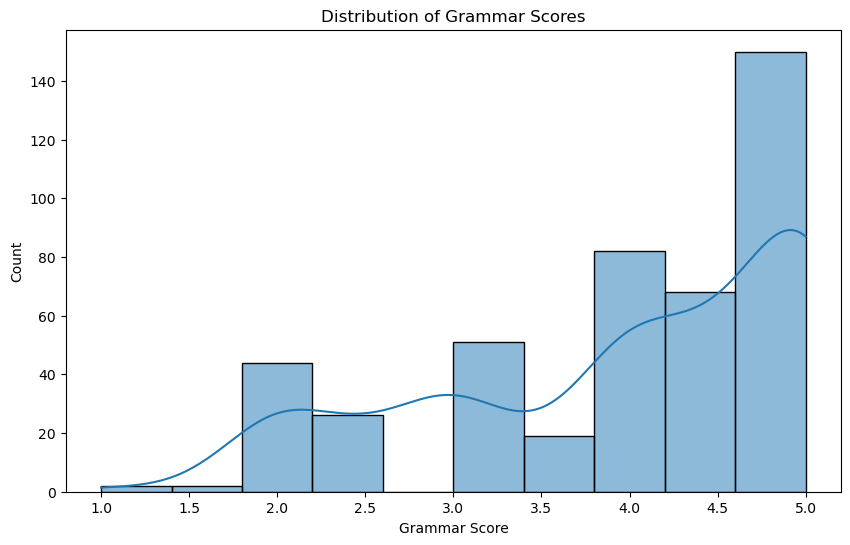

In [4]:
model.load_data(train_file='train.csv', test_file='test.csv')

In [5]:
model.extract_features(subset=5)

Loading pre-computed features from ./train_features.pkl


,duration,mean_energy,tempo,zero_crossing_rate,spectral_centroid_mean,spectral_bandwidth_mean,rms_mean,mfcc1_mean,mfcc1_std,mfcc2_mean,...,conjunction_count,speech_rate,audio_file,grammar_score,error_misspelling,error_uncategorized,error_grammar,error_duplication,error_locale_violation,error_whitespace
0,60.074688,0.022917,133.928571,0.150859,1652.834782,1421.570396,0.031372,-340.821472,80.339378,87.854080,...,0,123.845838,audio_710.wav,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,60.074688,0.010485,110.294118,0.143139,1812.681453,1710.677609,0.015064,-485.992737,127.466263,50.111820,...,2,169.788649,audio_1265.wav,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,60.074688,0.014858,125.000000,0.132682,2126.143258,1593.561943,0.021168,-468.621979,139.220428,55.773441,...,3,47.940324,audio_1114.wav,1.5,NaN,2.0,NaN,NaN,NaN,NaN
3,60.074688,0.028304,156.250000,0.105385,1962.232377,1590.935140,0.037655,-418.862366,134.786011,24.498125,...,4,38.951513,audio_946.wav,1.5,NaN,1.0,NaN,NaN,NaN,NaN
4,60.074688,0.035534,125.000000,0.155081,1751.896484,1533.526463,0.049667,-339.085052,111.981979,81.655800,...,11,114.857027,audio_1127.wav,2.0,NaN,1.0,NaN,NaN,NaN,NaN


In [6]:
model.extract_features(force_recompute=False, save_features=True)
test_features = model.extract_features(data_type='test')

Loading pre-computed features from ./train_features.pkl
Loading pre-computed features from ./test_features.pkl


In [7]:
# Option 1: Load pre-trained model if available
model_path = 'grammar_scoring_model.joblib'
model_loaded = model.load_model(model_path)

if not model_loaded:
    # Option 2: Train a new model
    display(Markdown("### Training a new model with cross-validation"))
    model.train_with_cross_validation(cv=5, model_type='random_forest')
    
    # Save the trained model 
    model.save_model(model_path)
    
    

Model loaded from grammar_scoring_model.joblib


In [8]:
# Get the test features
test_features = model.extract_features(data_type='test')

# Get the feature names that the model was trained with
# We can get these from the model's feature_names_ attribute
feature_names = model.model.feature_names_in_

# Create a DataFrame with the expected features (filled with zeros)
X_test = pd.DataFrame(0, index=range(len(test_features)), columns=feature_names)

# Fill in the values where we have them
exclude_cols = ['audio_file', 'transcription', 'grammar_score']
for col in feature_names:
    if col in test_features.columns:
        X_test[col] = test_features[col].fillna(0)

print(f"Prepared {len(X_test)} samples with {len(feature_names)} features")

# Make predictions
predictions = model.model.predict(X_test)

# Create results dataframe
results = pd.DataFrame({
    'audio_file': test_features['audio_file'],
    'predicted_score': predictions,
    'transcription': test_features['transcription']
})

# Create a submission dataframe with the required format
submission = pd.DataFrame({
    'filename': results['audio_file'],
    'label': results['predicted_score'].round(1)  # Round to 1 decimal place if needed
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print(f"Submission file created: submission.csv")

# Display the first few rows
display(submission.head(10))

Loading pre-computed features from ./test_features.pkl
Prepared 201 samples with 57 features
Submission file created: submission.csv


,filename,label
0,audio_804.wav,2.5
1,audio_1028.wav,3.0
2,audio_865.wav,2.8
3,audio_774.wav,2.9
4,audio_1138.wav,2.9
5,audio_278.wav,3.6
6,audio_1212.wav,3.6
7,audio_178.wav,4.1
8,audio_542.wav,2.9
9,audio_248.wav,3.2


In [9]:
test_features = model.extract_features(data_type='test')

Loading pre-computed features from ./test_features.pkl


In [10]:
test_files = model.test_data['audio_file'].tolist()
extracted_files = test_features['audio_file'].tolist()

In [11]:
missing_files = [f for f in test_files if f not in extracted_files]
print(f"Missing files: {missing_files}")

Missing files: ['audio_89.wav', 'audio_902.wav', 'audio_885.wav']


In [12]:
feature_names = model.model.feature_names_in_
feature_names

array(['duration', 'mean_energy', 'tempo', 'zero_crossing_rate',
       'spectral_centroid_mean', 'spectral_bandwidth_mean', 'rms_mean',
       'mfcc1_mean', 'mfcc1_std', 'mfcc2_mean', 'mfcc2_std', 'mfcc3_mean',
       'mfcc3_std', 'mfcc4_mean', 'mfcc4_std', 'mfcc5_mean', 'mfcc5_std',
       'mfcc6_mean', 'mfcc6_std', 'mfcc7_mean', 'mfcc7_std', 'mfcc8_mean',
       'mfcc8_std', 'mfcc9_mean', 'mfcc9_std', 'mfcc10_mean',
       'mfcc10_std', 'mfcc11_mean', 'mfcc11_std', 'mfcc12_mean',
       'mfcc12_std', 'mfcc13_mean', 'mfcc13_std', 'word_count',
       'error_count', 'error_density', 'sentence_count',
       'avg_sentence_length', 'avg_word_length', 'max_word_length',
       'linguistic_quality', 'error_style', 'error_typographical',
       'unique_words_ratio', 'comma_count', 'question_mark_count',
       'exclamation_count', 'pronoun_count', 'article_count',
       'conjunction_count', 'speech_rate', 'error_misspelling',
       'error_uncategorized', 'error_grammar', 'error_duplicati

In [13]:
X_test = pd.DataFrame(0, index=range(len(test_features)), columns=feature_names)

In [14]:
for col in feature_names:
    if col in test_features.columns:
        X_test[col] = test_features[col].fillna(0)

print(f"Prepared {len(X_test)} samples with {len(feature_names)} features")


Prepared 201 samples with 57 features


In [15]:
# Create a complete submission dataframe with all test files
# Start with the ones we have predictions for
submission = pd.DataFrame({
    'filename': results['audio_file'],
    'label': results['predicted_score'].round(1)
})

In [16]:
default_score = results['predicted_score'].mean().round(1)
for missing_file in missing_files:
    submission = pd.concat([submission, pd.DataFrame({
        'filename': [missing_file],
        'label': [default_score]
    })], ignore_index=True)

    

print(f"Added {len(missing_files)} missing files with default score: {default_score}")

submission['label'] = submission['label'].clip(2, 5)
submission['label'] = (submission['label'] * 2).round() / 2

Added 3 missing files with default score: 3.8


In [17]:
submission.to_csv('submission.csv', index=False)
print(f"Submission file created: submission.csv with {len(submission)} rows")

# Display the first few rows and some stats
display(submission.head(10))
print(f"Total files in submission: {len(submission)}")
print(f"Range of predictions: {submission['label'].min()} to {submission['label'].max()}")

Submission file created: submission.csv with 204 rows


,filename,label
0,audio_804.wav,2.5
1,audio_1028.wav,3.0
2,audio_865.wav,3.0
3,audio_774.wav,3.0
4,audio_1138.wav,3.0
5,audio_278.wav,3.5
6,audio_1212.wav,3.5
7,audio_178.wav,4.0
8,audio_542.wav,3.0
9,audio_248.wav,3.0


Total files in submission: 204
Range of predictions: 2.5 to 5.0
